In [1]:
import sqlite3
from sqlite3 import Error
import os.path
from os import path

#from create_db import create_connection, create_table, clean_column_names
#from populate_db import extract_data, insert_records
#import query_db as qd
import config
import build_dataset as build
import pipeline
import classification

import importlib
import datetime
import re
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve, plot_precision_recall_curve 

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
%matplotlib inline

In [3]:
importlib.reload(build)
importlib.reload(config)
importlib.reload(pipeline)
importlib.reload(classification)

<module 'classification' from '/Users/charmainerunes/git/covid_decarceration/files/classification.py'>

# Notebook table of contents:
1. Run all models for binary outcome variable. Run the best model according to F1 score and precision, predict on test data, calculate evaluation metrics
2. Repeat 1 without using demographic features
3. Repeat 1-2 on three-class outcome variable
4. Repeat 1-2 on 6-class outcome variable

In [4]:
# Import data - trim to 1994
dataset_3 = pd.read_csv('../data/dataset_main_active3.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (21,22,29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Set target
target = config.target_vars[0]

# Set year 
year = 1994

In [6]:
# Step 1
target_type = "binary"
features = "No Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
#train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

train_data, test_data, validate_data, active_sentences, active_almost_complete, dataset_no_active_norm = build.split_and_process(dataset_3, config,target_type,features,year)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)



248
Size of active sentences dataset:  31360
Dataset size:  527096


//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

Total Number of Unique IDs: 304786
Total Number of IDs in Test Data: 60957
Total Number of IDs in Train Data: 195063
Total Number of IDs in Validate Data: 48766
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.19999934380188067
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.8000006561981193
Does Validate Represent 20% of the Train+Validate Data?: 0.20000082024697635
Does Train Represent 80% of the Train+Validate Data?: 0.7999991797530236


/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

Index(['CONTROL_STATUS', 'OFFENSE_CLEAN', 'Current_Offense_Risk_Level',
       'year_month', 'INFRACTION_PER_SENT', 'misd_count', 'felon_count',
       'sentence_count', 'age_at_sentence', 'unemp_rate', 'ID',
       'COMMITMENT_PREFIX', 'BIRTH_DATE', 'EARLIEST_SENTENCE_EFFECTIVE_DT',
       'END_DATE', 'INMATE_ADMIN_STATUS_CODE', 'NextPrefix',
       'Recidivate_Risk_Level', 'age_cat', 'age_first_offense',
       'juv_first_offense', 'current_crime_violent'],
      dtype='object')


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match
Train and Active Almost Complete Check:
Success: Features match


In [7]:
#target = config.target_vars[0]
validate_data.groupby(target).count()


,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,CONTROL_STATUS_HIGH SECURITY/MAX CONTROL HCON,...,age_cat_25-29,age_cat_30-34,age_cat_35-39,age_cat_40-44,age_cat_45-49,age_cat_50-54,age_cat_55-59,age_cat_60-64,age_cat_65 and older,CONTROL_STATUS_OUT OF CELL RESTRICTION OUTC
Recidivate_Risk_Level,,,,,,,,,,,,,,,,,,,,,
0.0,58575,58575,58575,58575,58575,58575,58575,58575,58575,58575,...,58575,58575,58575,58575,58575,58575,58575,58575,58575,58575
1.0,25542,25542,25542,25542,25542,25542,25542,25542,25542,25542,...,25542,25542,25542,25542,25542,25542,25542,25542,25542,25542


In [8]:
# train_backup = train_data.copy()
# validate_backup = validate_data.copy()
# test_backup = test_data.copy()


In [9]:
# train_data = train_data.sample(10000)
# validate_data = validate_data.sample(5000)
# test_data = test_data.sample(3000)

Recidivate_Risk_Level
{'penalty': ['l2', 'none'], 'C': [0.01], 'max_iter': [1000]}
Running:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-package

{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recidivate_Risk_Level
Fitting best model


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature Importance


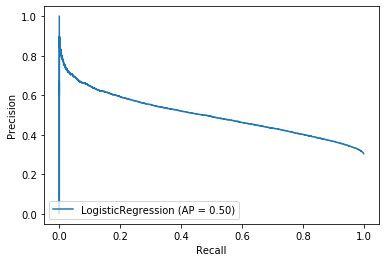

Confusion Matrix
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[68489  4967]
 [25169  6998]]
Accuracy:	0.7146833549510997
Precision:	0.5848725449226911
Recall:		0.21755214971865577
F1 Score:	0.31713949061905194

{'criterion': ['entropy'], 'max_depth': [10, 30], 'min_samples_split': [100]}
Running:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, split

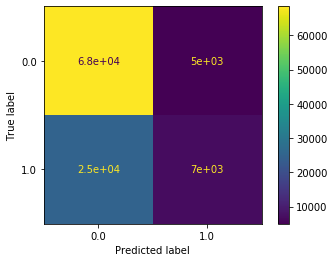

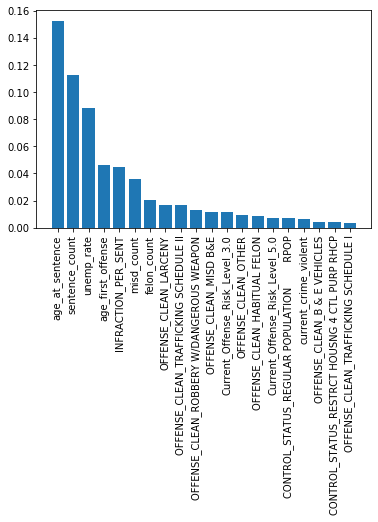

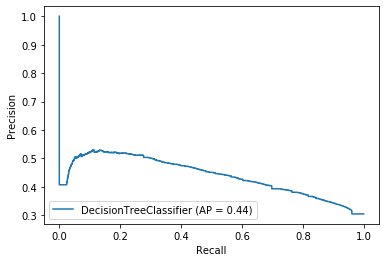

Confusion Matrix
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
[[64903  8553]
 [23255  8912]]
Accuracy:	0.6988534694148055
Precision:	0.5102776982536501
Recall:		0.2770541237914633
F1 Score:	0.3591231463571889

Time Elapsed: 0:07:05.066206


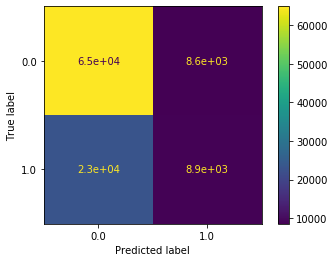

In [10]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type,features,year)

#best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
#results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)

In [11]:
results

,classifier,params,rank_test_precision,rank_test_recall,rank_test_accuracy,rank_test_f1,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
1,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}",2,1,1,1,0.680379,0.275266,0.587182,0.374743
0,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}",1,2,2,2,0.676688,0.198873,0.608442,0.299619
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 30, 'min...",2,1,2,1,0.653577,0.309961,0.503609,0.383733
0,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 10, 'min...",1,2,1,2,0.671241,0.272547,0.558011,0.365648


In [12]:
best_models

,classifier,test_accuracy,test_precision,test_recall,test_f1
0,"LogisticRegression(C=0.01, class_weight=None, ...",0.714683,0.584873,0.217552,0.317139
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.698853,0.510278,0.277054,0.359123


In [13]:
# Step 2
target_type = "binary"
features = "Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
#train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)
train_data, test_data, validate_data, active_sentences, active_almost_complete, dataset_no_active_norm = build.split_and_process(dataset_3, config,target_type,features,year)


# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)



248
Size of active sentences dataset:  31360
Dataset size:  527096


//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

Total Number of Unique IDs: 304786
Total Number of IDs in Test Data: 60957
Total Number of IDs in Train Data: 195063
Total Number of IDs in Validate Data: 48766
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.19999934380188067
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.8000006561981193
Does Validate Represent 20% of the Train+Validate Data?: 0.20000082024697635
Does Train Represent 80% of the Train+Validate Data?: 0.7999991797530236


/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

Index(['RACE', 'GENDER', 'ETHNICITY', 'CONTROL_STATUS', 'OFFENSE_CLEAN',
       'Current_Offense_Risk_Level', 'year_month', 'INFRACTION_PER_SENT',
       'misd_count', 'felon_count', 'sentence_count', 'age_at_sentence',
       'unemp_rate', 'ID', 'COMMITMENT_PREFIX', 'BIRTH_DATE',
       'EARLIEST_SENTENCE_EFFECTIVE_DT', 'END_DATE',
       'INMATE_ADMIN_STATUS_CODE', 'NextPrefix', 'Recidivate_Risk_Level',
       'age_cat', 'age_first_offense', 'juv_first_offense',
       'current_crime_violent'],
      dtype='object')


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match
Train and Active Almost Complete Check:
Success: Features match


In [14]:
validate_data.groupby(target).count()


,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,RACE_ASIAN/ORTL,...,age_cat_25-29,age_cat_30-34,age_cat_35-39,age_cat_40-44,age_cat_45-49,age_cat_50-54,age_cat_55-59,age_cat_60-64,age_cat_65 and older,CONTROL_STATUS_OUT OF CELL RESTRICTION OUTC
Recidivate_Risk_Level,,,,,,,,,,,,,,,,,,,,,
0.0,58575,58575,58575,58575,58575,58575,58575,58575,58575,58575,...,58575,58575,58575,58575,58575,58575,58575,58575,58575,58575
1.0,25542,25542,25542,25542,25542,25542,25542,25542,25542,25542,...,25542,25542,25542,25542,25542,25542,25542,25542,25542,25542


Recidivate_Risk_Level
{'penalty': ['l2', 'none'], 'C': [0.01], 'max_iter': [1000]}
Running:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-package

{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recidivate_Risk_Level
Fitting best model


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature Importance


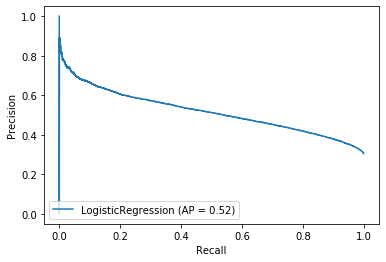

Confusion Matrix
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[67658  5798]
 [23951  8216]]
Accuracy:	0.7183473296535793
Precision:	0.5862708719851577
Recall:		0.2554170423104424
F1 Score:	0.3558173274723371

{'criterion': ['entropy'], 'max_depth': [10, 30], 'min_samples_split': [100]}
Running:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, spli

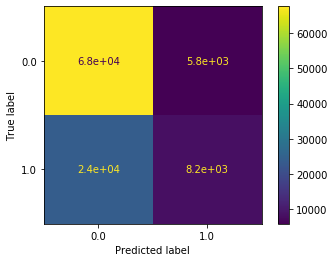

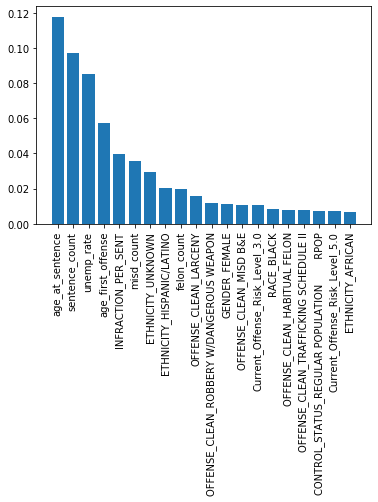

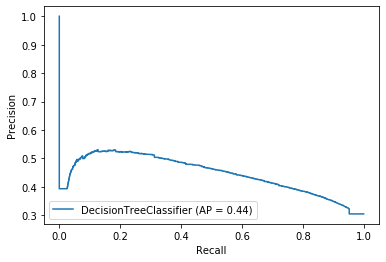

Confusion Matrix
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
[[63868  9588]
 [22116 10051]]
Accuracy:	0.6998381034433788
Precision:	0.511787769234686
Recall:		0.31246308328411104
F1 Score:	0.3880245531405629

Time Elapsed: 0:07:08.328572


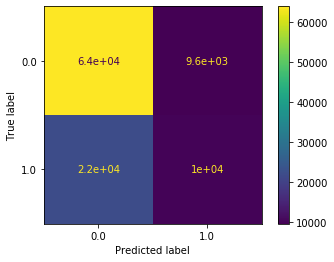

In [15]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type,features,year)

#best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
#results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [16]:
results

,classifier,params,rank_test_precision,rank_test_recall,rank_test_accuracy,rank_test_f1,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
1,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}",2,1,1,1,0.686494,0.340492,0.585806,0.430425
0,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}",1,2,2,2,0.683429,0.257180,0.606659,0.361127
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 30, 'min...",2,1,2,1,0.657405,0.375206,0.510713,0.432556
0,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 10, 'min...",1,2,1,2,0.673376,0.318098,0.554486,0.403419


In [17]:
best_models

,classifier,test_accuracy,test_precision,test_recall,test_f1
0,"LogisticRegression(C=0.01, class_weight=None, ...",0.718347,0.586271,0.255417,0.355817
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.699838,0.511788,0.312463,0.388025


In [18]:
# Step 3
target_type = "three_class"
features = "Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
#train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)
train_data, test_data, validate_data, active_sentences, active_almost_complete, dataset_no_active_norm = build.split_and_process(dataset_3, config,target_type,features,year)


# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

248
Size of active sentences dataset:  31360
Dataset size:  527096


//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

Total Number of Unique IDs: 304786
Total Number of IDs in Test Data: 60957
Total Number of IDs in Train Data: 195063
Total Number of IDs in Validate Data: 48766
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.19999934380188067
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.8000006561981193
Does Validate Represent 20% of the Train+Validate Data?: 0.20000082024697635
Does Train Represent 80% of the Train+Validate Data?: 0.7999991797530236


/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

Index(['RACE', 'GENDER', 'ETHNICITY', 'CONTROL_STATUS', 'OFFENSE_CLEAN',
       'Current_Offense_Risk_Level', 'year_month', 'INFRACTION_PER_SENT',
       'misd_count', 'felon_count', 'sentence_count', 'age_at_sentence',
       'unemp_rate', 'ID', 'COMMITMENT_PREFIX', 'BIRTH_DATE',
       'EARLIEST_SENTENCE_EFFECTIVE_DT', 'END_DATE',
       'INMATE_ADMIN_STATUS_CODE', 'NextPrefix', 'Recidivate_Risk_Level',
       'age_cat', 'age_first_offense', 'juv_first_offense',
       'current_crime_violent'],
      dtype='object')


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match
Train and Active Almost Complete Check:
Success: Features match


In [19]:
validate_data.groupby(target).count()


,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,RACE_ASIAN/ORTL,...,age_cat_25-29,age_cat_30-34,age_cat_35-39,age_cat_40-44,age_cat_45-49,age_cat_50-54,age_cat_55-59,age_cat_60-64,age_cat_65 and older,CONTROL_STATUS_OUT OF CELL RESTRICTION OUTC
Recidivate_Risk_Level,,,,,,,,,,,,,,,,,,,,,
0.0,71424,71424,71424,71424,71424,71424,71424,71424,71424,71424,...,71424,71424,71424,71424,71424,71424,71424,71424,71424,71424
1.0,9833,9833,9833,9833,9833,9833,9833,9833,9833,9833,...,9833,9833,9833,9833,9833,9833,9833,9833,9833,9833
2.0,2860,2860,2860,2860,2860,2860,2860,2860,2860,2860,...,2860,2860,2860,2860,2860,2860,2860,2860,2860,2860


In [20]:
# train_data = train_data.sample(10000)
# validate_data = validate_data.sample(5000)
# test_data = test_data.sample(3000)

Recidivate_Risk_Level
{'penalty': ['l2', 'none'], 'C': [0.01], 'max_iter': [1000]}
Running:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning

{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recidivate_Risk_Level
Fitting best model


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature Importance
Confusion Matrix
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[89490    66     3]
 [12448    52     3]
 [ 3551     9     1]]
Accuracy:	0.8477604309667403
Precision:	0.4668802864107476
Recall:		0.3345564600007667
F1 Score:	0.3088050596102161

{'criterion': ['entropy'], 'max_depth': [10, 30], 'min_samples_split': [100]}
Running:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='depreca

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 100}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
Recidivate_Risk_Level
Fitting best model
Feature Importance


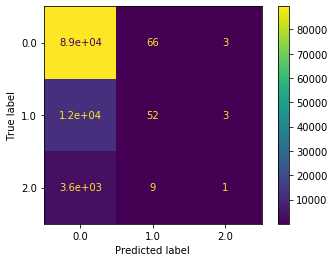

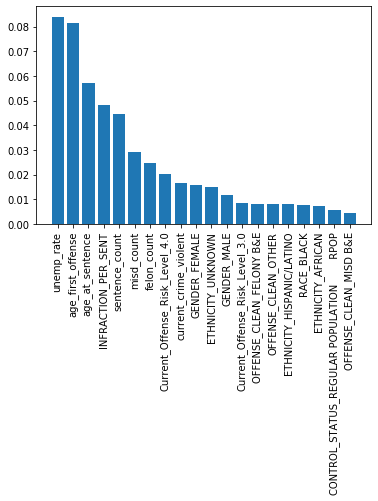

Confusion Matrix
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
[[87521  1619   419]
 [11969   467    67]
 [ 3393   106    62]]
Accuracy:	0.833625252075779
Precision:	0.39229029660058656
Recall:		0.34400197560355167
F1 Score:	0.3344399465375774

Time Elapsed: 0:24:23.126772


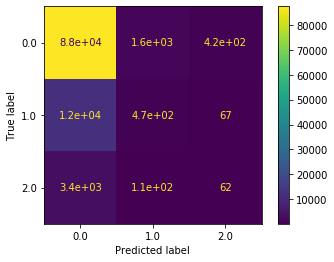

In [21]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type,features,year)
#best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
#results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [22]:
results

,classifier,params,rank_test_precision,rank_test_recall,rank_test_accuracy,rank_test_f1,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
1,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}",1,1,2,1,0.833170,0.334877,0.434285,0.307360
0,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}",2,2,1,2,0.834071,0.333222,0.282740,0.303201
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 30, 'min...",2,1,2,1,0.816921,0.337680,0.356563,0.322047
0,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 10, 'min...",1,2,1,2,0.831873,0.334192,0.357563,0.306808


In [23]:
best_models

,classifier,test_accuracy,test_precision,test_recall,test_f1
0,"LogisticRegression(C=0.01, class_weight=None, ...",0.847760,0.46688,0.334556,0.308805
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.833625,0.39229,0.344002,0.334440


In [24]:
# Step 4
target_type = "three_class"
features = "No Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
#train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)
train_data, test_data, validate_data, active_sentences, active_almost_complete, dataset_no_active_norm = build.split_and_process(dataset_3, config,target_type,features,year)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

248
Size of active sentences dataset:  31360
Dataset size:  527096


//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

Total Number of Unique IDs: 304786
Total Number of IDs in Test Data: 60957
Total Number of IDs in Train Data: 195063
Total Number of IDs in Validate Data: 48766
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.19999934380188067
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.8000006561981193
Does Validate Represent 20% of the Train+Validate Data?: 0.20000082024697635
Does Train Represent 80% of the Train+Validate Data?: 0.7999991797530236


/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

Index(['CONTROL_STATUS', 'OFFENSE_CLEAN', 'Current_Offense_Risk_Level',
       'year_month', 'INFRACTION_PER_SENT', 'misd_count', 'felon_count',
       'sentence_count', 'age_at_sentence', 'unemp_rate', 'ID',
       'COMMITMENT_PREFIX', 'BIRTH_DATE', 'EARLIEST_SENTENCE_EFFECTIVE_DT',
       'END_DATE', 'INMATE_ADMIN_STATUS_CODE', 'NextPrefix',
       'Recidivate_Risk_Level', 'age_cat', 'age_first_offense',
       'juv_first_offense', 'current_crime_violent'],
      dtype='object')


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match
Train and Active Almost Complete Check:
Success: Features match


In [25]:
validate_data.groupby(target).count()


,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,CONTROL_STATUS_HIGH SECURITY/MAX CONTROL HCON,...,age_cat_25-29,age_cat_30-34,age_cat_35-39,age_cat_40-44,age_cat_45-49,age_cat_50-54,age_cat_55-59,age_cat_60-64,age_cat_65 and older,CONTROL_STATUS_OUT OF CELL RESTRICTION OUTC
Recidivate_Risk_Level,,,,,,,,,,,,,,,,,,,,,
0.0,71424,71424,71424,71424,71424,71424,71424,71424,71424,71424,...,71424,71424,71424,71424,71424,71424,71424,71424,71424,71424
1.0,9833,9833,9833,9833,9833,9833,9833,9833,9833,9833,...,9833,9833,9833,9833,9833,9833,9833,9833,9833,9833
2.0,2860,2860,2860,2860,2860,2860,2860,2860,2860,2860,...,2860,2860,2860,2860,2860,2860,2860,2860,2860,2860


Recidivate_Risk_Level
{'penalty': ['l2', 'none'], 'C': [0.01], 'max_iter': [1000]}
Running:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning

{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recidivate_Risk_Level
Fitting best model


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature Importance
Confusion Matrix
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[89477    80     2]
 [12446    54     3]
 [ 3551     9     1]]
Accuracy:	0.8476562869829488
Precision:	0.46420711157044287
Recall:		0.3345613953013678
F1 Score:	0.308886162229254

{'criterion': ['entropy'], 'max_depth': [10, 30], 'min_samples_split': [100]}
Running:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='depreca

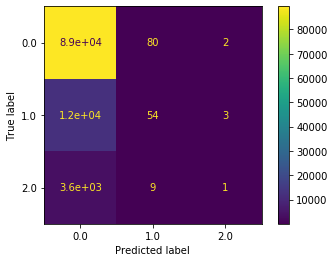

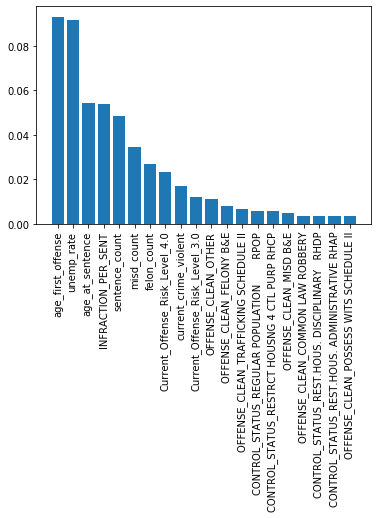

Confusion Matrix
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
[[87709  1531   319]
 [12027   411    65]
 [ 3430   107    24]]
Accuracy:	0.834515209755451
Precision:	0.369860895908196
Recall:		0.33965167227057486
F1 Score:	0.32625975883821556

Time Elapsed: 0:23:23.038636


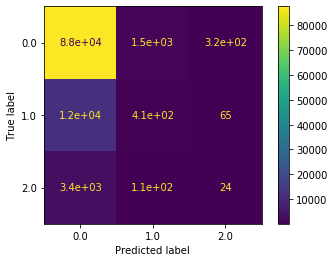

In [26]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type,features,year)
#best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
#results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [27]:
results

,classifier,params,rank_test_precision,rank_test_recall,rank_test_accuracy,rank_test_f1,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
1,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}",1,1,2,1,0.833325,0.334540,0.432157,0.306574
0,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}",2,2,1,2,0.834048,0.333213,0.281940,0.303196
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 30, 'min...",2,1,2,1,0.818080,0.338537,0.368532,0.322942
0,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 10, 'min...",1,2,1,2,0.830542,0.335195,0.401236,0.309783


In [28]:
best_models

,classifier,test_accuracy,test_precision,test_recall,test_f1
0,"LogisticRegression(C=0.01, class_weight=None, ...",0.847656,0.464207,0.334561,0.308886
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.834515,0.369861,0.339652,0.326260


In [29]:
# Step 5
target_type = "all"
features = "Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
#train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)
train_data, test_data, validate_data, active_sentences, active_almost_complete, dataset_no_active_norm = build.split_and_process(dataset_3, config,target_type,features,year)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

248
Size of active sentences dataset:  31360
Dataset size:  527096
Total Number of Unique IDs: 304786
Total Number of IDs in Test Data: 60957
Total Number of IDs in Train Data: 195063
Total Number of IDs in Validate Data: 48766
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.19999934380188067
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.8000006561981193
Does Validate Represent 20% of the Train+Validate Data?: 0.20000082024697635
Does Train Represent 80% of the Train+Validate Data?: 0.7999991797530236


/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

Index(['Recidivate_Risk_Level', 'RACE', 'GENDER', 'ETHNICITY',
       'CONTROL_STATUS', 'OFFENSE_CLEAN', 'Current_Offense_Risk_Level',
       'year_month', 'INFRACTION_PER_SENT', 'misd_count', 'felon_count',
       'sentence_count', 'age_at_sentence', 'unemp_rate', 'ID',
       'COMMITMENT_PREFIX', 'BIRTH_DATE', 'EARLIEST_SENTENCE_EFFECTIVE_DT',
       'END_DATE', 'INMATE_ADMIN_STATUS_CODE', 'NextPrefix', 'age_cat',
       'age_first_offense', 'juv_first_offense', 'current_crime_violent'],
      dtype='object')


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match
Train and Active Almost Complete Check:
Success: Features match


In [30]:
validate_data.groupby(target).count()


,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,RACE_ASIAN/ORTL,...,age_cat_25-29,age_cat_30-34,age_cat_35-39,age_cat_40-44,age_cat_45-49,age_cat_50-54,age_cat_55-59,age_cat_60-64,age_cat_65 and older,CONTROL_STATUS_OUT OF CELL RESTRICTION OUTC
Recidivate_Risk_Level,,,,,,,,,,,,,,,,,,,,,
0.0,58575,58575,58575,58575,58575,58575,58575,58575,58575,58575,...,58575,58575,58575,58575,58575,58575,58575,58575,58575,58575
1.0,5894,5894,5894,5894,5894,5894,5894,5894,5894,5894,...,5894,5894,5894,5894,5894,5894,5894,5894,5894,5894
2.0,6955,6955,6955,6955,6955,6955,6955,6955,6955,6955,...,6955,6955,6955,6955,6955,6955,6955,6955,6955,6955
3.0,9833,9833,9833,9833,9833,9833,9833,9833,9833,9833,...,9833,9833,9833,9833,9833,9833,9833,9833,9833,9833
4.0,2466,2466,2466,2466,2466,2466,2466,2466,2466,2466,...,2466,2466,2466,2466,2466,2466,2466,2466,2466,2466
5.0,394,394,394,394,394,394,394,394,394,394,...,394,394,394,394,394,394,394,394,394,394


Recidivate_Risk_Level
{'penalty': ['l2', 'none'], 'C': [0.01], 'max_iter': [1000]}
Running:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pred

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_wa

{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recidivate_Risk_Level
Fitting best model


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature Importance
Confusion Matrix
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[72904    45   234   264     9     0]
 [ 7168    33   119   127     4     0]
 [ 8235    26   286   102     3     0]
 [12035    42   140   283     3     0]
 [ 2985    12    48    40     1     0]
 [  455     0     6    13     1     0]]
Accuracy:	0.695937437868646
Precision:	0.2739441305405608
Recall:		0.17548813093847462
F1 Score:	0.155790910506129



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'criterion': ['entropy'], 'max_depth': [10, 30], 'min_samples_split': [100]}
Running:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning

{'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 100}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
Recidivate_Risk_Level
Fitting best model
Feature Importance


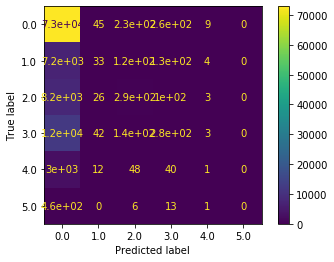

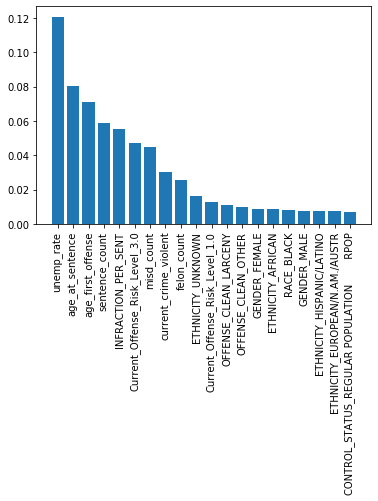

Confusion Matrix
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
[[70307   689   961  1314   166    19]
 [ 6729   172   235   283    27     5]
 [ 7627   144   525   327    26     3]
 [11223   202   346   687    38     7]
 [ 2781    51    79   128    46     1]
 [  436     6    10    22     1     0]]
Accuracy:	0.6791797241131193
Precision:	0.2481924570286567
Recall:		0.18512456680063136
F1 Score:	0.17810861869439962

Time Elapsed: 0:46:51.909596


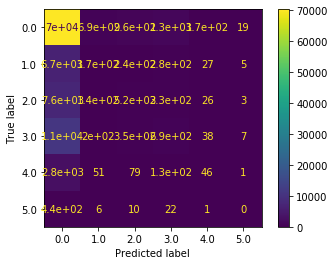

In [31]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type,features,year)
#best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
#results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [32]:
results

,classifier,params,rank_test_precision,rank_test_recall,rank_test_accuracy,rank_test_f1,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
1,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}",1,1,1,1,0.659880,0.195908,0.367432,0.181016
0,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}",2,2,2,2,0.659585,0.189349,0.310474,0.167950
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 30, 'min...",2,1,2,1,0.640360,0.193634,0.250275,0.182451
0,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 10, 'min...",1,2,1,2,0.655016,0.185670,0.265661,0.162822


In [33]:
best_models

,classifier,test_accuracy,test_precision,test_recall,test_f1
0,"LogisticRegression(C=0.01, class_weight=None, ...",0.695937,0.273944,0.175488,0.155791
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.679180,0.248192,0.185125,0.178109


In [34]:
# Step 6
target_type = "all"
features = "No Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
#train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)
train_data, test_data, validate_data, active_sentences, active_almost_complete, dataset_no_active_norm = build.split_and_process(dataset_3, config,target_type,features,year)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

248
Size of active sentences dataset:  31360
Dataset size:  527096
Total Number of Unique IDs: 304786
Total Number of IDs in Test Data: 60957
Total Number of IDs in Train Data: 195063
Total Number of IDs in Validate Data: 48766
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.19999934380188067
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.8000006561981193
Does Validate Represent 20% of the Train+Validate Data?: 0.20000082024697635
Does Train Represent 80% of the Train+Validate Data?: 0.7999991797530236


/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

Index(['Recidivate_Risk_Level', 'CONTROL_STATUS', 'OFFENSE_CLEAN',
       'Current_Offense_Risk_Level', 'year_month', 'INFRACTION_PER_SENT',
       'misd_count', 'felon_count', 'sentence_count', 'age_at_sentence',
       'unemp_rate', 'ID', 'COMMITMENT_PREFIX', 'BIRTH_DATE',
       'EARLIEST_SENTENCE_EFFECTIVE_DT', 'END_DATE',
       'INMATE_ADMIN_STATUS_CODE', 'NextPrefix', 'age_cat',
       'age_first_offense', 'juv_first_offense', 'current_crime_violent'],
      dtype='object')


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match
Train and Active Almost Complete Check:
Success: Features match


In [35]:
validate_data.groupby(target).count()


,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,CONTROL_STATUS_HIGH SECURITY/MAX CONTROL HCON,...,age_cat_25-29,age_cat_30-34,age_cat_35-39,age_cat_40-44,age_cat_45-49,age_cat_50-54,age_cat_55-59,age_cat_60-64,age_cat_65 and older,CONTROL_STATUS_OUT OF CELL RESTRICTION OUTC
Recidivate_Risk_Level,,,,,,,,,,,,,,,,,,,,,
0.0,58575,58575,58575,58575,58575,58575,58575,58575,58575,58575,...,58575,58575,58575,58575,58575,58575,58575,58575,58575,58575
1.0,5894,5894,5894,5894,5894,5894,5894,5894,5894,5894,...,5894,5894,5894,5894,5894,5894,5894,5894,5894,5894
2.0,6955,6955,6955,6955,6955,6955,6955,6955,6955,6955,...,6955,6955,6955,6955,6955,6955,6955,6955,6955,6955
3.0,9833,9833,9833,9833,9833,9833,9833,9833,9833,9833,...,9833,9833,9833,9833,9833,9833,9833,9833,9833,9833
4.0,2466,2466,2466,2466,2466,2466,2466,2466,2466,2466,...,2466,2466,2466,2466,2466,2466,2466,2466,2466,2466
5.0,394,394,394,394,394,394,394,394,394,394,...,394,394,394,394,394,394,394,394,394,394


Recidivate_Risk_Level
{'penalty': ['l2', 'none'], 'C': [0.01], 'max_iter': [1000]}
Running:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pred

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recidivate_Risk_Level
Fitting best model


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature Importance
Confusion Matrix
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[72967    44   185   254     6     0]
 [ 7200    27   104   118     2     0]
 [ 8308    19   225    98     2     0]
 [12083    40   130   249     1     0]
 [ 2992    10    43    40     1     0]
 [  461     0     4    10     0     0]]
Accuracy:	0.6955776677428211
Precision:	0.271189039126638
Recall:		0.17386857342445627
F1 Score:	0.15262708863373928

{'criterion': ['entropy'], 'max_depth': [10, 30], 'min_samples_split': [100]}
Running:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_de

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning

{'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 100}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
Recidivate_Risk_Level
Fitting best model
Feature Importance


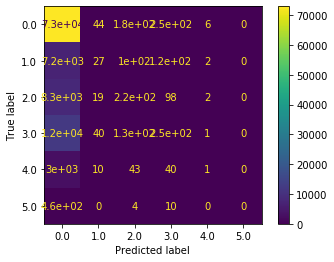

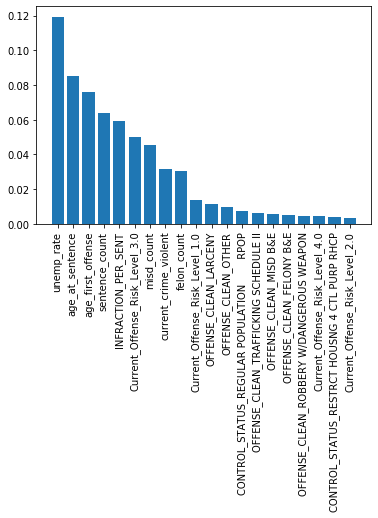

Confusion Matrix
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
[[70318   708   958  1298   142    32]
 [ 6696   200   239   290    25     1]
 [ 7618   163   527   313    23     8]
 [11295   212   345   615    32     4]
 [ 2818    51    81   113    23     0]
 [  431     7    12    23     1     1]]
Accuracy:	0.6786779394639425
Precision:	0.24150934578393066
Recall:		0.18396330453384213
F1 Score:	0.17607092477471964

Time Elapsed: 0:36:52.649780


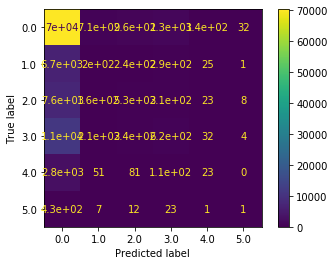

In [36]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type,features,year)
#best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
#results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [37]:
results

,classifier,params,rank_test_precision,rank_test_recall,rank_test_accuracy,rank_test_f1,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
1,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}",1,1,1,1,0.658900,0.193370,0.390111,0.177151
0,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}",2,2,2,2,0.658279,0.186132,0.304178,0.163014
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 30, 'min...",2,1,2,1,0.639778,0.195214,0.249233,0.185105
0,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 10, 'min...",1,2,1,2,0.654944,0.186594,0.268912,0.164471


In [38]:
best_models

,classifier,test_accuracy,test_precision,test_recall,test_f1
0,"LogisticRegression(C=0.01, class_weight=None, ...",0.695578,0.271189,0.173869,0.152627
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.678678,0.241509,0.183963,0.176071
